# Notebook to train the dataset on Microsoft Custom Vision

Just as last time, we do the following.
- import the packages
- connect to our Custom Vision portal
- Based on the labels(categories) create the tags in our Just created Custom Vision project
- Convert every image to a ImageFileEntry to be able to insert(upload) it into Custom Vision
- Train an iteration (train a model)
- Show model result by using the prediction endpoint
- Sample couple images from the prediction endpoint

In [47]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt

from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient
from azure.cognitiveservices.vision.customvision.training.models import ImageFileCreateBatch, ImageFileCreateEntry
from msrest.authentication import ApiKeyCredentials

In [3]:
ENDPOINT = "https://fernando-custom-vision.cognitiveservices.azure.com/"

training_key = "5004d3eb4bab4070b4d4f2dae87d3bd2"
prediction_key = "e83b5e40972c4bd9bc06750755c5cf5a"
prediction_resource_id = "/subscriptions/101c228b-7ec2-48c2-b9d3-f012863db5b7/resourceGroups/ai-resourcegroup/providers/Microsoft.CognitiveServices/accounts/fernando-custom-vision"

publish_iteration_name = "Iteration1"

credentials = ApiKeyCredentials(in_headers={"Training-key": training_key})
trainer = CustomVisionTrainingClient(ENDPOINT, credentials)

# Get project
print ("Getting project...")
project = trainer.get_project('2db08055-de01-4ad3-afce-36cbcc420693')
project

Getting project...


# Get images from file system.
Get images from file system and put them into a Dataframe

In [4]:
filenames = os.listdir("input/data/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

# Create tags in the project

Seeing the distribution of the dataset, that leads to 2 unique (dog and cat) categories, so 2 tags will be created in this Custom Vision project.

In [10]:
# change to text, so we can create tags based on category
df.category = df.category.replace({1: 'dog', 0: 'cat'})

In [13]:
# Get existing tags if exist in this project
existing_tags = []
for existing_tag in trainer.get_tags(project_id=project.id):
    existing_tags.append(existing_tag.name)

for tag in df.category:
    if tag in existing_tags:
        print(f'Tag: {tag} already exist in Custom Vision project')
    else:
        trainer.create_tag(project.id, tag)
        print(f'Just created tag: {tag}')


# if (trainer.get_tags(project_id=project.id)[0].name == 'Cat' or trainer.get_tags(project_id=project.id)[1].name == 'Dog'): 
#     print('Tags already created')
#     print('How a tag looks:', trainer.get_tags(project_id=project.id)[0])

#     cat_tag = trainer.get_tags(project_id=project.id)[0]
#     dog_tag = trainer.get_tags(project_id=project.id)[1]
# else:
#     # Make two tags in the new project
#     dog_tag = trainer.create_tag(project.id, "Dog")
#     cat_tag = trainer.create_tag(project.id, "Cat")

1
Cat
0
Dog


## Create Custom Vision ImageFileEntre from image

Create a helper function to create batches and retrieve existing tag

In [14]:
def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

In [15]:
def get_existing_tag_id(check_tag_name):
    for tag in trainer.get_tags(project.id):
        if (check_tag_name == tag.name):
            return tag.id
    return None

## if you need to delete image batches from CV
This code delete the length of the array of images.

In [26]:
for b in batch(df.filename.values, 64):
    trainer.delete_images(project.id, image_ids=b)

When you need to delete all the tags in the project

In [ ]:
for tag in trainer.get_tags(project.id):
    trainer.delete_tag(project.id, tag.id)

## Create the images
This code uploads each image with its corresponding tag. You can upload up to 64 images in a single batch.

In [27]:
for b in batch(df.values, 64):
    image_list = []
    for i, row in enumerate(b):
        image, category = row
        if get_existing_tag_id(category) == None:
            new_tag = trainer.create_tag(project.id, category)
            with open('input/data/train/'+image, 'rb') as image_contents:
                image_list.append(ImageFileCreateEntry(name=image, contents=image_contents.read(), tag_ids=[new_tag.id]))
        else:
            t_id = get_existing_tag_id(category)
            with open('input/data/train/'+image, 'rb') as image_contents:
                image_list.append(ImageFileCreateEntry(name=image, contents=image_contents.read(), tag_ids=[t_id]))

    upload_result = trainer.create_images_from_files(project.id, ImageFileCreateBatch(images=image_list))
    if not upload_result.is_batch_successful:
        print("Image batch upload failed.")
        for image in upload_result.images:
            print("Image status: ", image.status)
        exit(-1)

Image batch upload failed.
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OKDuplicate
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image status:  OK
Image stat

# Train for an iteration

Lets create model now!

In [28]:
iteration = trainer.train_project(project_id=project.id)
while iteration.status != "Completed":
    iteration = trainer.get_iteration(project.id, iteration.id)
    print(f'Training status: {iteration.status}')
    time.sleep(1)

ning
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Trainin

Publish the iteration to use the Prediction endpoint.

Publish it to the project endpoint. So that we can use the Custom Service prediction endpoint. 

The name given to the published iteration can be used to send prediction requests. 

An iteration is not available in the prediction endpoint until it is published.

In [35]:
iterations = trainer.get_iterations(project_id=project.id)
last_iteration_id = ''
last_iteration_name = ''
for iteration in iterations[::]:
    last_iteration_id = iteration.id
    last_iteration_name = iteration.name

In [36]:
last_iteration_id

'0c39d075-83fc-4071-a48b-9d50e575760b'

In [37]:
trainer.publish_iteration(project.id, last_iteration_id, last_iteration_name, prediction_resource_id)

CustomVisionErrorException: Invalid prediction id, please pass a prediction resource id.

# Use the prediction endpoint
To send an image to the prediction endpoint and retrieve the prediction, add the following code to the end of the file.

In [38]:
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
from msrest.authentication import ApiKeyCredentials

In [39]:
prediction_credentials = ApiKeyCredentials(in_headers={'Prediction-Key': prediction_key})
predictor = CustomVisionPredictionClient(ENDPOINT, prediction_credentials)
print(predictor)

Test the prediction endpoint with one file.

Also create helper class for getting prediction via Prediction API

In [45]:
def custom_vision_prediction(img):
    t = []
    p = []
    with open('input/data/test1/' + img, 'rb') as image_contents:
        results = predictor.classify_image(project.id, 'Iteration2', image_contents.read())    
        for pred in results.predictions[:5]: # limit the result to top 5 predictions
            t.append(pred.tag_name)
            p.append(pred.probability)
        
        return t, p

Visualize the result from Custom Vision prediction result

You see that it will give a dog or cat.

1 = dog
0 = cat

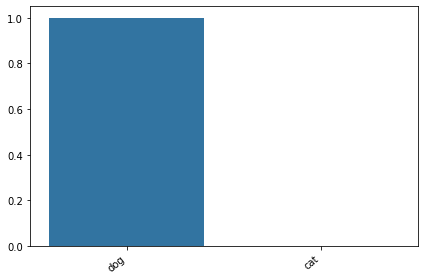

In [48]:
t, p = custom_vision_prediction('1.jpg')

ax = sns.barplot(x=t, y=p)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha='right')
plt.tight_layout()
plt.show()

# Sample couple of images
Lets grab 5 images from the test set and send them to Custom Vision Predictor API and see what the results are.

In [49]:
import os
import numpy as np
import random
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator

In [51]:
test_images = os.listdir("input/data/test1")
sample_test_set = random.choices(test_images, k=5)

In [52]:
sample_test_set

['10338.jpg', '1420.jpg', '4880.jpg', '420.jpg', '5341.jpg']

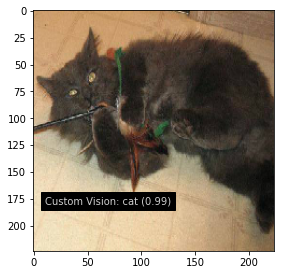

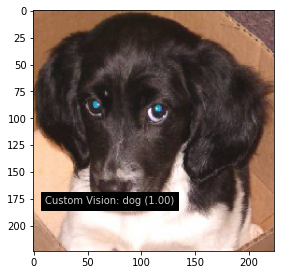

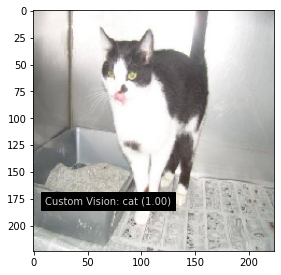

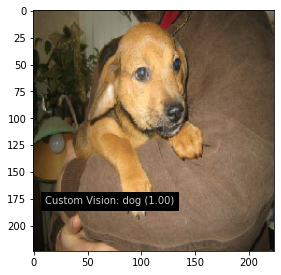

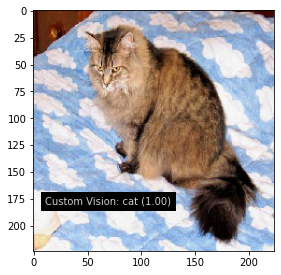

In [54]:
for i, filename in enumerate(sample_test_set):
    plt.figure(figsize=(25,25))
    plt.subplot(1, 5, i+1)
    img = image.load_img('input/data/test1/'+filename, target_size=(224, 224))
    tag, pred = custom_vision_prediction(filename)
    # plt.text(10, 180, 'Probability: %s' % , color='w', backgroundcolor='k', alpha=0.8)
    plt.text(10, 180, 'Custom Vision: %s (%.2f)' % (tag[0], pred[0]), color='w', backgroundcolor='k', alpha=0.8)
    plt.imshow(img)
    plt.show()